# Modelling part

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from jupyterthemes import jtplot
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
tqdm_notebook().pandas()
# jtplot.style(theme='grade3')
%matplotlib inline

In [2]:
#### Checking how many NEW TICKETS do we crawl PER DAY ####

# full = pd.read_csv('with_proper_updates.csv', index_col = 0)
# full['last_date'] = full['date_checks'].progress_apply(lambda x: x.split(',')[-1])
# print(full.last_date.max())
# full['first_date'] = full['date_checks'].progress_apply(lambda x: x.split(',')[0])
# print(full[(full.first_date >= '2018-10-23 03:30:01') & (full.num_checks == 1)].shape)
# print(full[(full.last_date >= '2018-10-23 03:30:01')].shape)

# Number of new tickets per day is around 55646
# Number of all tickets checked per day is 404566 
# Fraction = 55646 / 404566 * 100% = 13,75%

# Data analysis

## Analysing categorical features and clustering

In [ ]:
# Extracting sample from the file
filename = 'data_1.csv'
n = sum(1 for line in open(filename)) - 1 # number of records in file (excludes header)
s = n # desired sample size
skip = sorted(random.sample(range(1, n+1), n-s)) # the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip, index_col = 0)

In [ ]:
df[['departure_id', 'arrival_id', 'company_id', 'num_updates', 'life', 'recency', 'time_left', 'last_check', 'expired_early']]

In [9]:
data = df[['departure_id', 'arrival_id', 'departure_time', 'arrival_time', 'conditions', 'flixbus', 'company_id',
       'ouibus', 'distribusion', 'top95', 'num_updates', 'life', 'recency', 'available', 'time_left', 'last_check', 'expired_early', 'label']]
del skip, df

In [4]:
# Checking for total null values
df.isnull().sum()

departure_id            0
arrival_id              0
company_id              0
departure_date          0
arrival_date            0
conditions              0
num_checks              0
date_checks       1242454
prices            1242454
updated_prices    1242454
available               0
last_date               0
first_check             0
last_check        1242454
update_index            0
last_update       3547071
label                   0
index_minus_k           0
flixbus                 0
ouibus                  0
distribusion            0
top95                   0
last_seen               0
departure_time          0
arrival_time            0
time_left               0
num_updates             0
life                    0
recency                 0
expired_early           0
dtype: int64

In [ ]:
f,ax=plt.subplots(1,2,figsize=(16,7))
data['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Updated')
ax[0].set_ylabel('')
sns.countplot('label',data=data,ax=ax[1])
ax[1].set_title('Updated')
plt.show()

In [ ]:
print(' Minimum number of updates per ticket: {}'.format(data.num_updates.min()))
print(' Maximum number of updates per ticket: {}'.format(data.num_updates.max()))

In [ ]:
# g_num_updates -> number of dozens of updates per ticket
data['g_num_updates'] = data['num_updates'].apply(lambda x: x // 10)

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['g_num_updates','label']].groupby(['g_num_updates']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Updated vs Num of updates')
sns.countplot('g_num_updates',hue='label',data=data,ax=ax[1])
ax[1].set_title('Num of updates: Updated vs Not')
# plt.ylim([0, 10000])
plt.show()

In [ ]:
data[data.num_updates > 80]

In [11]:
data.company_id.value_counts()

2      1491946
24      689963
56      511077
20      405174
3       393320
7       150421
65      108489
18      100280
9        95322
16       75784
70       65708
5        63204
14       58532
6        49516
53       36052
8        35274
28       34187
13       32940
62       24056
30       24026
79       20358
95       19944
54       15564
34       14796
119      14684
102      14490
75       13269
32       12195
76       11496
74       10296
        ...   
128       1172
64        1111
113       1052
59         965
55         842
86         652
31         469
81         340
11         261
100        254
69         251
82         248
26         197
66         182
99         163
73         159
98         150
121        143
91         138
57          70
126         62
72          37
106         12
52          11
44           3
131          1
136          1
165          1
152          1
167          1
Name: company_id, Length: 94, dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4757173 entries, 0 to 4764371
Data columns (total 18 columns):
departure_id      int64
arrival_id        int64
departure_time    object
arrival_time      object
conditions        int64
flixbus           int64
company_id        int64
ouibus            int64
distribusion      int64
top95             int64
num_updates       int64
life              int64
recency           int64
available         int64
time_left         int64
last_check        object
expired_early     int64
label             int64
dtypes: int64(15), object(3)
memory usage: 689.6+ MB


In [13]:
data.company_id.value_counts().iloc[:30].index

Int64Index([  2,  24,  56,  20,   3,   7,  65,  18,   9,  16,  70,   5,  14,
              6,  53,   8,  28,  13,  62,  30,  79,  95,  54,  34, 119, 102,
             75,  32,  76,  74],
           dtype='int64')

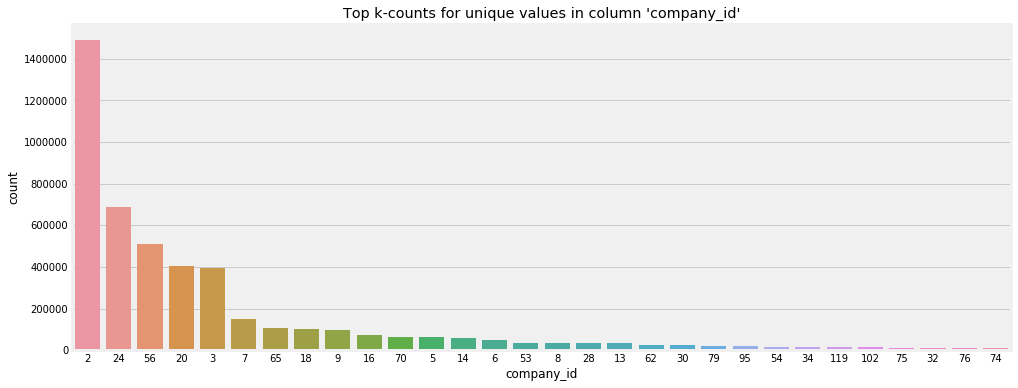

In [10]:
plt.figure(figsize = (15,6))
sns.countplot(x='company_id', data=data, order = data.company_id.value_counts().iloc[:30].index)
plt.title('Top k-counts for unique values in column \'company_id\'')
# plt.legend(loc='upper right', title='Company_id')
# plt.xticks([i for i in sorted(data.company_id.unique.tolist())]) # mapping from binary variable to qualitative responses
plt.show()

In [ ]:
c_counts = list(data.company_id.value_counts().to_dict().values())
total = sum(c_counts)

In [ ]:
# Take 95% percentile
bound_index = 0
value_sum = 0
for i in c_counts:
    value_sum += i
    if value_sum < int(total * 0.95):
        bound_index += 1
    else:
        print(' value_at_index ' + str(i))
        break
print(' sum ' + str(value_sum))
print(' bound ' + str(bound_index))
print(int(total * 0.95))
top_95_companies = list(data.company_id.value_counts().index)[:23]

In [ ]:
%store top_95_companies

In [ ]:
#two-way table
grouped = data.groupby(['company_id', 'label'])
grouped.size()

In [ ]:
table = pd.crosstab(index=data["company_id"], columns=data["num_updates"])
table

In [ ]:
table.plot(kind="bar", figsize=(8,8), stacked=True, range=(0, 10))

In [ ]:
c = data.company_id.values
plt.figure(figsize=(25, 8))
plt.hist(c, bins=data.company_id.nunique(), range=(0, 20));

In [ ]:
data.head()

# Analysing current algorithm

In [ ]:
last_date = data.last_check.max()
day = data[data.last_check ==  last_date]
day['days_from_now'] = day.apply(lambda row: (datetime.strptime(row['departure_date'], '%Y-%m-%d') - datetime.strptime(last_date, '%Y-%m-%d')).days, axis=1)

In [ ]:
day

## Grouping tickets

In [ ]:
%%time
from statistics import median
data = data.groupby(['departure_id', 'arrival_id', 'departure_time', 'arrival_time', 'conditions', 'company_id'], 
                as_index = False).agg(dict(num_updates = 'mean',  life = 'mean', recency = lambda x: median(x), label = 'max'))

In [ ]:
# Apply one hot encoding to columns with categorical variables
data = pd.get_dummies(data, columns=['company_id', 'conditions'])
data = data.drop(['departure_id', 'arrival_id', 'departure_time', 'arrival_time'], axis = 1)

In [ ]:
# 
features = list(data.columns)
features.remove('label')
X = data[features]
X.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

scaler = RobustScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])

In [ ]:
%%time
x_train, x_test, y_train, y_test = train_test_split(principalDf, data[['label']], test_size=0.25, random_state=0, stratify=data[['label']])
# class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train.label),
#                                                  y_train.label)))
# model = LogisticRegression(class_weight=class_weights)
model = LogisticRegressionCV(class_weight='balanced', penalty='l2', cv = 3)
# Fit..
model.fit(x_train, y_train)
# Predict..
pred = model.predict(x_test)
# Evaluate the model
print(confusion_matrix(y_test, pred))
print(f1_score(y_test, pred), recall_score(y_test, pred))

In [ ]:
# Show results for training set
train_pred = model.predict(x_train)
# Evaluate the model
print(confusion_matrix(y_train, train_pred))
print(f1_score(y_train, train_pred), recall_score(y_train, train_pred))

In [ ]:
# # Sampling from dataframe
# sample = df.sample(frac=0.1, replace=False)
# sample = sample[['conditions', 'company_id', 'num_updates', 'life', 'recency', 'label']]
# sample = pd.get_dummies(sample, columns=['company_id', 'conditions'])

In [ ]:
del (data, X, x_train, x_test, y_train, y_test)

# Sample of 1.2 mln rows

In [ ]:
# Show results for the entire dataset
filename = 'data.csv'
n = sum(1 for line in open(filename)) - 1 # number of records in file (excludes header)
s = 1200000 # desired sample size
skip = sorted(random.sample(range(1, n+1), n-s)) # the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip, index_col = 0)

In [ ]:
df = df[['departure_id', 'arrival_id', 'departure_time', 'arrival_time', 'conditions', 'company_id', 'num_updates', 'life', 'recency', 'label']]

In [ ]:
df = pd.get_dummies(df, columns=['company_id', 'conditions'])
df = df.drop(['departure_id', 'arrival_id', 'departure_time', 'arrival_time'], axis = 1)

In [ ]:
features = list(df.columns)
features.remove('label')
X = df[features]
X.head()

In [ ]:
from sklearn.decomposition import PCA
scaler = RobustScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])

In [ ]:
pred = model.predict(principalDf)
# Evaluate the model
print(confusion_matrix(df[['label']], pred))
print(f1_score(df[['label']], pred), recall_score(df[['label']], pred))

In [ ]:
# If new columns should be added:
# columns_to_add = []
# for col in list(data.columns):
#     if col not in list(df.columns):
#         columns_to_add.append(col)
# for col in columns_to_add:
#     df[col] = 0

In [ ]:
features = list(principalDf.columns)
features.remove('label')
X_sample = principalDf[features]

In [ ]:
scaler = RobustScaler()
X_sample = scaler.fit_transform(X_sample)

In [ ]:
xs_train, xs_test, ys_train, ys_test = train_test_split(X_sample, sample[['label']], test_size=0.25, random_state=42, stratify=y)

In [ ]:
train_pred = model.predict(xs_train)
print(confusion_matrix(ys_train, train_pred))
print(f1_score(y_test, pred), recall_score(ys_train, train_pred))

In [ ]:
results_with_L1 = '0.12956721046245112 0.2631578947368421'
results_simple_L1_CV = '0.13310298204762264 0.15827338129496402'

In [ ]:
from sklearn.model_selection import GridSearchCV
weights = np.linspace(0.05, 0.95, 20)

scaler = RobustScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(x_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)
model = RandomForestClassifier(**grid_result.best_params_)
# class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train.label),
#                                                  y_train.label)))
# model = LogisticRegression(class_weight = class_weights)
# Fit..
model.fit(x_train, y_train)
# Predict..
pred = model.predict(x_test)
# Evaluate the model
confusion_matrix(y_test, pred)
print(confusion_matrix(y_test, pred))
print(f1_score(y_test, pred), recall_score(y_test, pred))

Results after feature selection (RF with class_weights parameter) --> f1_score, recall respectively:
1)  basic model: 0.04695982627578719 0.7990762124711316
2) + conditions: 0.03765502814165463 0.8729792147806005
3) + company_id: 0.04280869516873297 0.8891454965357968
4) + company_id
   + conditions: 0.04235371973749518 0.8868360277136259

-  RF with one-hot encoding: 0.20949902407286922 0.371824480369515
                           : 0.2049062049062049 0.3279445727482679


# Feature selection using all combinations of models (but without dummy variables)

In [ ]:
from itertools import chain, combinations
def powerset(iterable):
    # "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

all_features = ['company_id', 'num_updates', 'life', 'recency', 'available']
pset = [i for i in powerset(all_features)]
pset.remove(())

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight

results_dict = dict()
for i in pset:
    features = list(i)
    X = data[features]
    x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train.label),
                                                 y_train.label)))
    model = LogisticRegression(class_weight=class_weights)
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    results_dict[i] = (f1_score(y_test, pred), recall_score(y_test, pred))

In [ ]:
results_dict

Winners here are:
1) ('company_id', 'num_updates', 'life', 'recency'): (0.041514573685644235,
  0.8799076212471132)
2) ('num_updates', 'life', 'recency', 'available'): (0.04740559630535181,
  0.8060046189376443),
3) ('company_id', 'life', 'recency', 'available'): (0.03892630744849446,
  0.9076212471131639)
4) 

# Simple model

In [ ]:
features = ['num_updates', 'life', 'recency', 'available']
X = data[features]
X.head()

In [ ]:
from sklearn.model_selection import GridSearchCV
weights = np.linspace(0.05, 0.95, 25)

scaler = RobustScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)
gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(x_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
model = RandomForestClassifier(**grid_result.best_params_)
# Fit..
model.fit(x_train, y_train)
# Predict..
pred = model.predict(x_test)
# Evaluate the model
confusion_matrix(y_test, pred)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score, recall_score

# scaler = RobustScaler()
# X = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)
x_test.reset_index(inplace = True)
x_test = x_test.drop(columns = 'index')
y_test.reset_index(inplace = True)
y_test = y_test.drop(columns = 'index')

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score

class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train.label),
                                                 y_train.label)))

model = RandomForestClassifier(class_weight=class_weights)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(y_test, pred))
print(f1_score(y_test, pred), recall_score(y_test, pred))

In [ ]:
pred = pd.DataFrame(pred)
pred.columns = ['predicted_label']
prediction = pd.concat([x_test, y_test, pred], axis = 1)

In [ ]:
prediction[(prediction.label != prediction.predicted_label) & (prediction.label == 1)]

In [ ]:
for w in [250, 275, 300, 325, 350]:
    print('---Weight of {} for update class---'.format(w))
    model = RandomForestClassifier(class_weight={0:1, 1:w})
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print(confusion_matrix(y_test, pred))
    print(f1_score(y_test, pred), recall_score(y_test, pred))

In [ ]:
from sklearn.model_selection import GridSearchCV
weights = [230, 240, 250, 260, 270]

gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: 1, 1: x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(x_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
rf = RandomForestClassifier(**grid_result.best_params_)
# Fit..
rf.fit(x_train, y_train)

# Predict..
y_pred = rf.predict(x_test)
confusion_matrix(y_test, y_pred)

In [ ]:
train_pred = rf.predict(x_train)
confusion_matrix(y_train, train_pred)

# Oversampling

In [ ]:
labelled = data[data.label == 1]
data = data[data.label == 0]

In [ ]:
data.reset_index(inplace=True)
data = data.drop(['index'], axis = 1)

In [ ]:
rows_indexes = list(np.random.choice(data.shape[0], int(labelled.shape[0]*0.7/0.3), replace = False))

In [ ]:
data = data[data.index.isin(rows_indexes)]

In [ ]:
data = pd.concat([data, labelled])

In [ ]:
data = data.sort_index(ascending=True)

In [ ]:
X = data[['company_id', 'conditions', 'num_updates', 'life', 'recency', 'available']]
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, data[['label']], test_size=0.25, random_state=0)

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.ensemble import GradientBoostingClassifier

# class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train.label),
#                                                  y_train.label)))
model = LogisticRegression()

In [ ]:
# from sklearn.metrics import confusion_matrix
# for w in [50, 100, 250, 350, 450]:
#     print('---Weight of {} for Fraud class---'.format(w))
#     lr_model = RandomForestClassifier(class_weight={0:1, 1:w})
#     lr_model.fit(x_train,y_train)

#     pred = lr_model.predict(x_test)
#     print(confusion_matrix(y_test, pred))

In [ ]:
rf = RandomForestClassifier()
# Fit..
rf.fit(x_train, y_train)

# Predict..
y_pred = rf.predict(x_test)
confusion_matrix(y_test, y_pred)

In [ ]:
train_pred = rf.predict(x_train)
confusion_matrix(y_train, train_pred)

In [ ]:
# Compute confusion matrix and retrieve all values
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
tp, fp, fn, tp = (confusion_matrix(y_test, y_pred)[0, 0], 
                 confusion_matrix(y_test, y_pred)[0, 1], 
                 confusion_matrix(y_test, y_pred)[1, 0],
                 confusion_matrix(y_test, y_pred)[1, 1])
confusion_matrix(y_test, y_pred)

In [ ]:
# Compute all classification metrics for test set
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f1_score = 2*(precision*recall)/(precision+recall)

print("Recall score for test set: {0: .2f} %".format(recall * 100))
print("Precision score for test set: {0: .2f} %".format(precision * 100))
print("F1-score for test set: {0: .2f} %".format(f1_score* 100))

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto'],
    'max_depth' : [4,8]
}
rfc=RandomForestClassifier(random_state=42)
gsc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='f1', cv=3)
grid_result = gsc.fit(x_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

In [ ]:
rf = RandomForestClassifier(**grid_result.best_params_)

# Fit..
rf.fit(x_train, y_train)

# Predict..
y_pred = rf.predict(x_test)
confusion_matrix(y_test, y_pred)

In [ ]:
# Compute confusion matrix and retrieve all values
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
tp, fp, fn, tp = (confusion_matrix(y_test, y_pred)[0, 0], 
                 confusion_matrix(y_test, y_pred)[0, 1], 
                 confusion_matrix(y_test, y_pred)[1, 0],
                 confusion_matrix(y_test, y_pred)[1, 1])
confusion_matrix(y_test, y_pred)

In [ ]:
# Compute all classification metrics for test set
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f1_score = 2*(precision*recall)/(precision+recall)

print("Recall score for test set: {0: .2f} %".format(recall * 100))
print("Precision score for test set: {0: .2f} %".format(precision * 100))
print("F1-score for test set: {0: .2f} %".format(f1_score* 100))

In [ ]:
train_pred = rf.predict(x_train)
confusion_matrix(y_train, train_pred)

# Initial model

In [ ]:
#### CHECKPOINT ####
filename = 'data.csv'
# df.to_csv(filename)
df = pd.read_csv(filename, index_col = 0)

In [ ]:
full_data = df[['company_id', 'conditions', 'num_updates', 'life', 'recency', 'label', 'available']]
full_data = full_data[['company_id', 'conditions', 'num_updates', 'life', 'recency', 'available']]
full_data.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
full_data = scaler.fit_transform(full_data)
x_train, x_test, y_train, y_test = train_test_split(full_data, df[['label']], test_size=0.25, random_state=0)

In [ ]:
train_pred = rf.predict(x_train)
confusion_matrix(y_train, train_pred)

In [ ]:
# Compute confusion matrix and retrieve all values
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
tp, fp, fn, tp = (confusion_matrix(y_train, train_pred)[0, 0], 
                 confusion_matrix(y_train, train_pred)[0, 1], 
                 confusion_matrix(y_train, train_pred)[1, 0],
                 confusion_matrix(y_train, train_pred)[1, 1])
confusion_matrix(y_train, train_pred)

In [ ]:
# Compute all classification metrics for test set
recall = tp /(tp + fn)
precision = tp / (tp + fp)
f1_score = 2*(precision*recall)/(precision+recall)

print("Recall score for test set: {0: .2f} %".format(recall * 100))
print("Precision score for test set: {0: .2f} %".format(precision * 100))
print("F1-score for test set: {0: .2f} %".format(f1_score* 100))

In [ ]:
# model = LogisticRegression(class_weight = class_weights, C=0.5)
model = LogisticRegression()
model.fit(x_train, y_train)

In [ ]:
# Predict using model
predict = pd.DataFrame(model.predict(x_test))
predict.columns = ['prediction']
predict[predict.prediction == 1].shape[0]

In [ ]:
# For clearer tables reset all indexes
# x_test.reset_index(inplace = True)
# x_test = x_test.drop(columns = 'index')
# y_test.reset_index(inplace = True)
# y_test = y_test.drop(columns = 'index')

In [ ]:
predict_train = pd.DataFrame(model.predict(x_train))
predict_train.columns = ['prediction']

In [ ]:
recall_score(y_train.label, predict_train.prediction)

In [ ]:
confusion_matrix(y_train.label, predict_train.prediction)

In [ ]:
1/((1182+150)/(data.shape[0]-(1182+150)))

In [ ]:
1/0.5008910151954213*281.0788288288288